In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]
ZR_46_TR, ZR_46_TE= ZR_46[0:250], ZR_46[250:len(ZR_46)]
ZR_12_TR, ZR_12_TE= ZR_12[0:50], ZR_12[50:len(ZR_12)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N
ZR_N46=ZR_N[-400:]
ZR_N12=ZR_N[-100:]

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]
ZR_N46_TR, ZR_N46_TE= ZR_N46[0:250], ZR_N46[250:len(ZR_N46)]
ZR_N12_TR, ZR_N12_TE= ZR_N12[0:50], ZR_N12[50:len(ZR_N12)]

In [6]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [7]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+1
look_back=12
look_forward=1

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_46_TR_I=timeseries_to_supervised_R(ZR_46_TR, look_back, look_forward)
trainX_46, train_y_46 = ZR_46_TR_I.iloc[:, 0:-1], ZR_46_TR_I.iloc[:, -1]

# Testdaten 
ZR_46_TE_I=timeseries_to_supervised_R(ZR_46_TE, look_back, look_forward)
testX_46, test_y_46 = ZR_46_TE_I.iloc[:, 0:-1], ZR_46_TE_I.iloc[:, -1]


# Inputgröße 12%
# Trainingsdaten
ZR_12_TR_I=timeseries_to_supervised_R(ZR_12_TR, look_back, look_forward)
trainX_12, train_y_12 = ZR_12_TR_I.iloc[:, 0:-1], ZR_12_TR_I.iloc[:, -1]

# Testdaten 
ZR_12_TE_I=timeseries_to_supervised_R(ZR_12_TE, look_back, look_forward)
testX_12, test_y_12 = ZR_12_TE_I.iloc[:, 0:-1], ZR_12_TE_I.iloc[:, -1]

In [8]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)
trainX_100N, train_y_100N = ZR_N100_TR_I.iloc[:, 0:-1], ZR_N100_TR_I.iloc[:, -1]

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)
testX_100N, test_y_100N = ZR_N100_TE_I.iloc[:, 0:-1], ZR_N100_TE_I.iloc[:, -1]


# Inputgröße 46%
# Trainingsdaten
ZR_N46_TR_I=timeseries_to_supervised_R(ZR_N46_TR, look_back, look_forward)
trainX_46N, train_y_46N = ZR_N46_TR_I.iloc[:, 0:-1], ZR_N46_TR_I.iloc[:, -1]

# Testdaten 
ZR_N46_TE_I=timeseries_to_supervised_R(ZR_N46_TE, look_back, look_forward)
testX_46N, test_y_46N = ZR_N46_TE_I.iloc[:, 0:-1], ZR_N46_TE_I.iloc[:, -1]


# Inputgröße 12%
# Trainingsdaten
ZR_N12_TR_I=timeseries_to_supervised_R(ZR_N12_TR, look_back, look_forward)
trainX_12N, train_y_12N = ZR_N12_TR_I.iloc[:, 0:-1], ZR_N12_TR_I.iloc[:, -1]

# Testdaten 
ZR_N12_TE_I=timeseries_to_supervised_R(ZR_N12_TE, look_back, look_forward)
testX_12N, test_y_12N = ZR_N12_TE_I.iloc[:, 0:-1], ZR_N12_TE_I.iloc[:, -1]

In [27]:
# Replizierbarkeit gewährleisten
np.random.seed(3)

In [28]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100N, train_y_100N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_100N, test_y_100N))

Train on 593 samples, validate on 246 samples
Epoch 1/200
 - 1s - loss: 0.6768 - val_loss: 0.1153
Epoch 2/200
 - 0s - loss: 0.3343 - val_loss: 0.0143
Epoch 3/200
 - 0s - loss: 0.1539 - val_loss: 0.0110
Epoch 4/200
 - 0s - loss: 0.0778 - val_loss: 0.0443
Epoch 5/200
 - 0s - loss: 0.0533 - val_loss: 0.0755
Epoch 6/200
 - 0s - loss: 0.0477 - val_loss: 0.0943
Epoch 7/200
 - 0s - loss: 0.0467 - val_loss: 0.0986
Epoch 8/200
 - 0s - loss: 0.0465 - val_loss: 0.1027
Epoch 9/200
 - 0s - loss: 0.0465 - val_loss: 0.1040
Epoch 10/200
 - 0s - loss: 0.0465 - val_loss: 0.1020
Epoch 11/200
 - 0s - loss: 0.0465 - val_loss: 0.1010
Epoch 12/200
 - 0s - loss: 0.0464 - val_loss: 0.1032
Epoch 13/200
 - 0s - loss: 0.0465 - val_loss: 0.0998
Epoch 14/200
 - 0s - loss: 0.0464 - val_loss: 0.1033
Epoch 15/200
 - 0s - loss: 0.0464 - val_loss: 0.1032
Epoch 16/200
 - 0s - loss: 0.0463 - val_loss: 0.1006
Epoch 17/200
 - 0s - loss: 0.0463 - val_loss: 0.1010
Epoch 18/200
 - 0s - loss: 0.0462 - val_loss: 0.1018
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0020 - val_loss: 0.0048
Epoch 155/200
 - 0s - loss: 0.0020 - val_loss: 0.0053
Epoch 156/200
 - 0s - loss: 0.0021 - val_loss: 0.0048
Epoch 157/200
 - 0s - loss: 0.0020 - val_loss: 0.0048
Epoch 158/200
 - 0s - loss: 0.0020 - val_loss: 0.0052
Epoch 159/200
 - 0s - loss: 0.0020 - val_loss: 0.0042
Epoch 160/200
 - 0s - loss: 0.0019 - val_loss: 0.0046
Epoch 161/200
 - 0s - loss: 0.0020 - val_loss: 0.0048
Epoch 162/200
 - 0s - loss: 0.0020 - val_loss: 0.0042
Epoch 163/200
 - 0s - loss: 0.0019 - val_loss: 0.0040
Epoch 164/200
 - 0s - loss: 0.0020 - val_loss: 0.0050
Epoch 165/200
 - 0s - loss: 0.0020 - val_loss: 0.0043
Epoch 166/200
 - 0s - loss: 0.0019 - val_loss: 0.0039
Epoch 167/200
 - 0s - loss: 0.0019 - val_loss: 0.0045
Epoch 168/200
 - 0s - loss: 0.0020 - val_loss: 0.0040
Epoch 169/200
 - 0s - loss: 0.0019 - val_loss: 0.0042
Epoch 170/200
 - 0s - loss: 0.0019 - val_loss: 0.0045
Epoch 171/200
 - 0s - loss: 0.0020 - val_loss: 0.0038
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

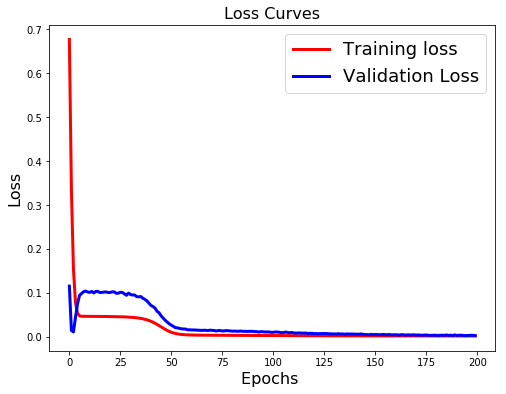

In [29]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [30]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100N, train_y_100N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100N, test_y_100N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.05 RMSE)


In [31]:
# Vorhersagen generieren
trainPredict_100N = model.predict(trainX_100N)
testPredict_100N = model.predict(testX_100N)

In [32]:
# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(testPredict_100N)
trainPredict_100=scaler.inverse_transform(trainPredict_100N)

# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

16050015.30794978 11246098.61176762


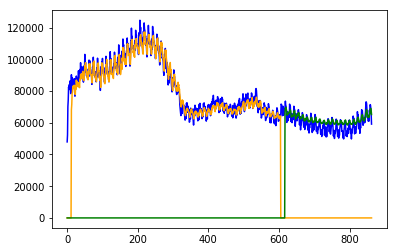

In [33]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+(2*look_back+look_forward-1):len(ZR_100)-(look_back+look_forward-1)+look_back] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [34]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [35]:
# Modell zusammenbauen
# Dateninput: 46 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_46N, train_y_46N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_46N, test_y_46N))

Train on 238 samples, validate on 138 samples
Epoch 1/200
 - 1s - loss: 0.0386 - val_loss: 0.0479
Epoch 2/200
 - 0s - loss: 0.0114 - val_loss: 0.0173
Epoch 3/200
 - 0s - loss: 0.0063 - val_loss: 0.0099
Epoch 4/200
 - 0s - loss: 0.0071 - val_loss: 0.0105
Epoch 5/200
 - 0s - loss: 0.0066 - val_loss: 0.0139
Epoch 6/200
 - 0s - loss: 0.0062 - val_loss: 0.0152
Epoch 7/200
 - 0s - loss: 0.0063 - val_loss: 0.0157
Epoch 8/200
 - 0s - loss: 0.0063 - val_loss: 0.0145
Epoch 9/200
 - 0s - loss: 0.0062 - val_loss: 0.0143
Epoch 10/200
 - 0s - loss: 0.0063 - val_loss: 0.0140
Epoch 11/200
 - 0s - loss: 0.0063 - val_loss: 0.0151
Epoch 12/200
 - 0s - loss: 0.0063 - val_loss: 0.0149
Epoch 13/200
 - 0s - loss: 0.0063 - val_loss: 0.0156
Epoch 14/200
 - 0s - loss: 0.0063 - val_loss: 0.0146
Epoch 15/200
 - 0s - loss: 0.0062 - val_loss: 0.0148
Epoch 16/200
 - 0s - loss: 0.0062 - val_loss: 0.0144
Epoch 17/200
 - 0s - loss: 0.0062 - val_loss: 0.0140
Epoch 18/200
 - 0s - loss: 0.0063 - val_loss: 0.0152
Epoch 19/

Epoch 154/200
 - 0s - loss: 0.0017 - val_loss: 0.0022
Epoch 155/200
 - 0s - loss: 0.0017 - val_loss: 0.0021
Epoch 156/200
 - 0s - loss: 0.0017 - val_loss: 0.0021
Epoch 157/200
 - 0s - loss: 0.0017 - val_loss: 0.0021
Epoch 158/200
 - 0s - loss: 0.0017 - val_loss: 0.0021
Epoch 159/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 160/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 161/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 162/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 163/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 164/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 165/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 166/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 167/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 168/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 169/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 170/200
 - 0s - loss: 0.0016 - val_loss: 0.0020
Epoch 171/200
 - 0s - loss: 0.0016 - val_loss: 0.0021
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

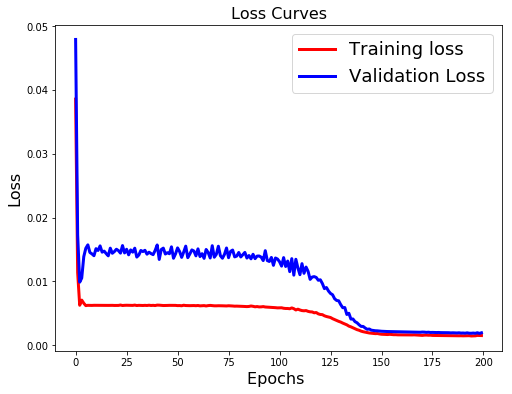

In [36]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [37]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_46N, train_y_46N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_46N, test_y_46N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)


In [38]:
# Vorhersagen generieren
trainPredict_46N = model.predict(trainX_46N)
testPredict_46N = model.predict(testX_46N)

In [39]:
# Prediction Denormalizing
testPredict_46=scaler.inverse_transform(testPredict_46N)
trainPredict_46=scaler.inverse_transform(trainPredict_46N)



# Evaluation
test_MSE=mean_squared_error(test_y_46,testPredict_46)
train_MSE=mean_squared_error(train_y_46,trainPredict_46)

print(test_MSE,train_MSE)

11530756.514901202 8689661.326103274


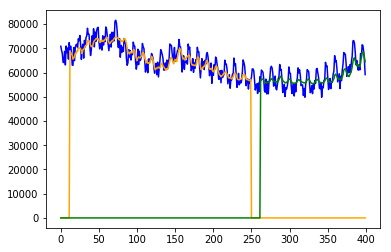

In [40]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_46))
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_46)+(look_back+look_forward-1)] = trainPredict_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot=testPredictPlot.reshape(len(ZR_46))
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(trainPredict_46)+(2*look_back+look_forward-1):len(ZR_46)-(look_back+look_forward-1)+look_back] = testPredict_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [65]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [66]:
# Modell zusammenbauen
# Dateninput: 12 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_12N, train_y_12N, epochs=200, batch_size=25, verbose=2,validation_data=(testX_12N, test_y_12N))

Train on 38 samples, validate on 38 samples
Epoch 1/200
 - 1s - loss: 0.0154 - val_loss: 0.0041
Epoch 2/200
 - 0s - loss: 0.0107 - val_loss: 0.0048
Epoch 3/200
 - 0s - loss: 0.0069 - val_loss: 0.0065
Epoch 4/200
 - 0s - loss: 0.0044 - val_loss: 0.0090
Epoch 5/200
 - 0s - loss: 0.0029 - val_loss: 0.0120
Epoch 6/200
 - 0s - loss: 0.0025 - val_loss: 0.0151
Epoch 7/200
 - 0s - loss: 0.0026 - val_loss: 0.0179
Epoch 8/200
 - 0s - loss: 0.0030 - val_loss: 0.0199
Epoch 9/200
 - 0s - loss: 0.0034 - val_loss: 0.0209
Epoch 10/200
 - 0s - loss: 0.0036 - val_loss: 0.0209
Epoch 11/200
 - 0s - loss: 0.0036 - val_loss: 0.0201
Epoch 12/200
 - 0s - loss: 0.0034 - val_loss: 0.0186
Epoch 13/200
 - 0s - loss: 0.0030 - val_loss: 0.0170
Epoch 14/200
 - 0s - loss: 0.0027 - val_loss: 0.0154
Epoch 15/200
 - 0s - loss: 0.0025 - val_loss: 0.0139
Epoch 16/200
 - 0s - loss: 0.0025 - val_loss: 0.0126
Epoch 17/200
 - 0s - loss: 0.0025 - val_loss: 0.0117
Epoch 18/200
 - 0s - loss: 0.0026 - val_loss: 0.0112
Epoch 19/20

Epoch 154/200
 - 0s - loss: 0.0025 - val_loss: 0.0133
Epoch 155/200
 - 0s - loss: 0.0025 - val_loss: 0.0126
Epoch 156/200
 - 0s - loss: 0.0025 - val_loss: 0.0122
Epoch 157/200
 - 0s - loss: 0.0025 - val_loss: 0.0122
Epoch 158/200
 - 0s - loss: 0.0025 - val_loss: 0.0124
Epoch 159/200
 - 0s - loss: 0.0025 - val_loss: 0.0129
Epoch 160/200
 - 0s - loss: 0.0025 - val_loss: 0.0133
Epoch 161/200
 - 0s - loss: 0.0025 - val_loss: 0.0136
Epoch 162/200
 - 0s - loss: 0.0025 - val_loss: 0.0139
Epoch 163/200
 - 0s - loss: 0.0025 - val_loss: 0.0140
Epoch 164/200
 - 0s - loss: 0.0025 - val_loss: 0.0137
Epoch 165/200
 - 0s - loss: 0.0025 - val_loss: 0.0131
Epoch 166/200
 - 0s - loss: 0.0025 - val_loss: 0.0128
Epoch 167/200
 - 0s - loss: 0.0025 - val_loss: 0.0127
Epoch 168/200
 - 0s - loss: 0.0025 - val_loss: 0.0129
Epoch 169/200
 - 0s - loss: 0.0025 - val_loss: 0.0134
Epoch 170/200
 - 0s - loss: 0.0025 - val_loss: 0.0136
Epoch 171/200
 - 0s - loss: 0.0025 - val_loss: 0.0139
Epoch 172/200
 - 0s - loss: 

Text(0.5,1,'Loss Curves')

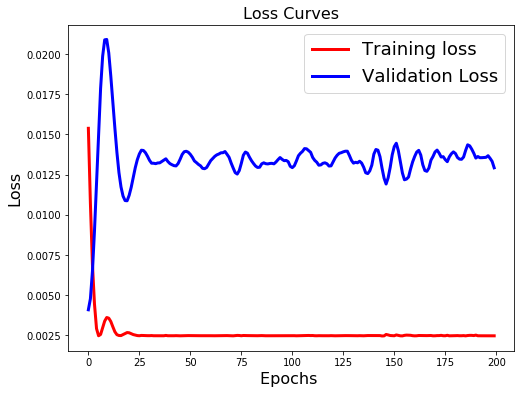

In [67]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [68]:
# Modellperformance bewerten
trainScore = model.evaluate(trainX_12N, train_y_12N, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_12N, test_y_12N, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 0.01 MSE (0.11 RMSE)


In [69]:
# Vorhersagen generieren
trainPredict_12N = model.predict(trainX_12N)
testPredict_12N = model.predict(testX_12N)

In [70]:
# Prediction Denormalizing
testPredict_12=scaler.inverse_transform(testPredict_12N)
trainPredict_12=scaler.inverse_transform(trainPredict_12N)

# Evaluation
test_MSE=mean_squared_error(test_y_12,testPredict_12)
train_MSE=mean_squared_error(train_y_12,trainPredict_12)

print(test_MSE,train_MSE)

76064203.88202426 14586536.889047321


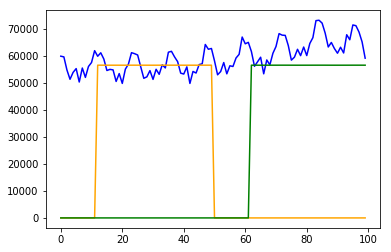

In [71]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_12)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_12))
trainPredictPlot[:]=[0]*len(ZR_12)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_12),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_12)+(look_back+look_forward-1)] = trainPredict_12

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_12)
testPredictPlot=testPredictPlot.reshape(len(ZR_12))
testPredictPlot[:]=[0]*len(ZR_12)
testPredictPlot = testPredictPlot.reshape(len(ZR_12),1)
testPredictPlot[len(trainPredict_12)+(2*look_back+look_forward-1):len(ZR_12)-(look_back+look_forward-1)+look_back] = testPredict_12
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_12, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()